In [2]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load Data

In [3]:
# Define Paths
base_path = "/content/drive/MyDrive/GAN-BarlowTwins"
script_path = f"{base_path}/STGAN-Finetune-BarlowTwins"
image_root = f"{base_path}/training_images"
csv_path = f"{base_path}/ISIC2018_Task3_Training_GroundTruth.csv"
pretrained_ckpt = f"{base_path}/all_70000.pth"
checkpoints = f"{base_path}/checkpoints"
temp_gen_dir = f"{base_path}/generated_temp"
real_mel_dir = f"{base_path}/mel_real_images"

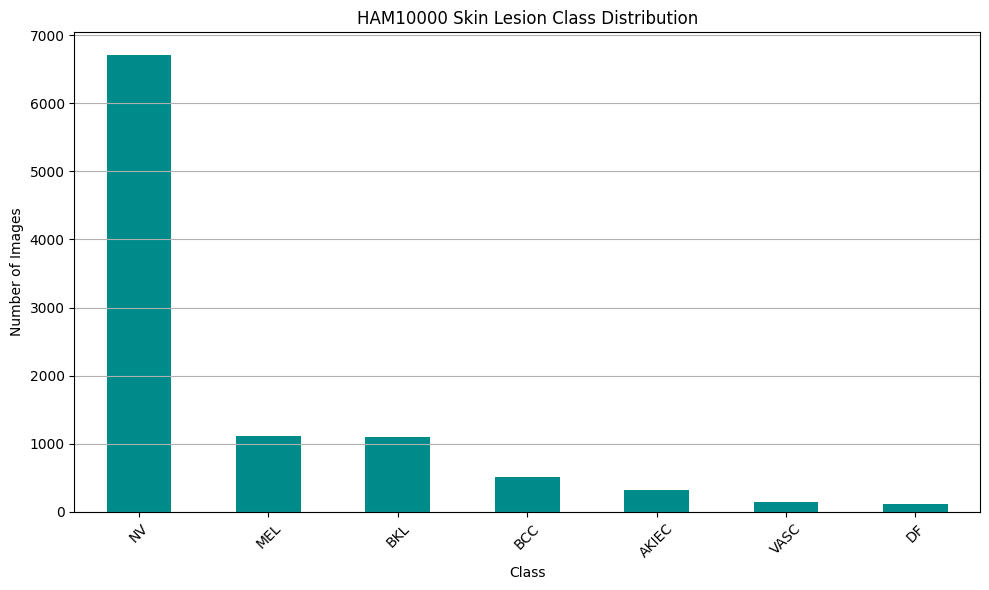

In [4]:
# Class Distribution in HAM10000
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV
df = pd.read_csv(csv_path)

# Count number of samples for each class (sum of one-hot encoded columns)
class_counts = df.iloc[:, 1:].sum().sort_values(ascending=False)

# Plot the distribution
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='darkcyan')
plt.title("HAM10000 Skin Lesion Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
# Check data fo NAs
import os

# Load label file
df = pd.read_csv(csv_path)

# Filter for DF class (one-hot encoded)
df_mel = df[df["MEL"] == 1.0].copy()
print(f"Total MEL samples in CSV: {len(df_mel)}")

# Build full image paths and verify they exist
df_mel["image_path"] = df_mel["image"].apply(lambda x: os.path.join(image_root, f"{x}.jpg"))
df_mel = df_mel[df_mel["image_path"].apply(os.path.exists)].reset_index(drop=True)

print(f"Valid image files found: {len(df_mel)}")
df_mel.head()

Total MEL samples in CSV: 1113
Valid image files found: 1113


,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,image_path
0,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/GAN-BarlowTwins/trainin...
1,ISIC_0024313,1.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/GAN-BarlowTwins/trainin...
2,ISIC_0024315,1.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/GAN-BarlowTwins/trainin...
3,ISIC_0024323,1.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/GAN-BarlowTwins/trainin...
4,ISIC_0024333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/GAN-BarlowTwins/trainin...


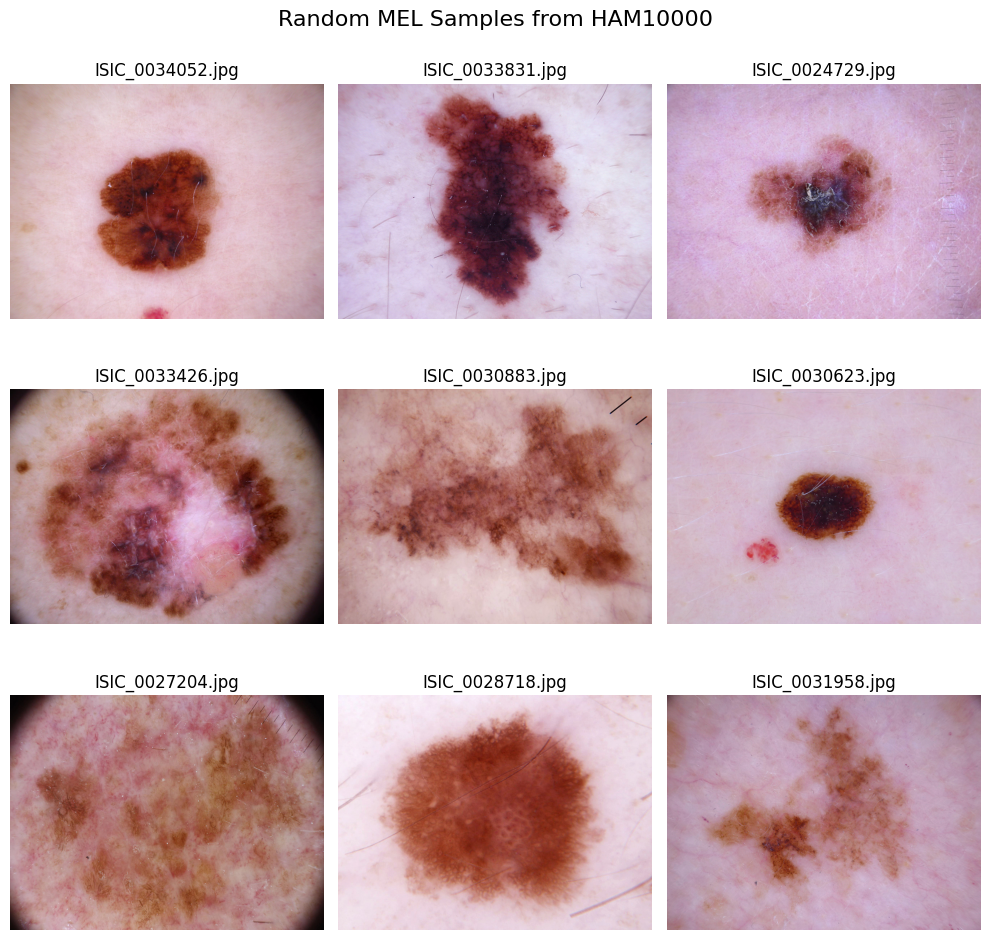

In [6]:
# Plot a Few Random DF Samples
from PIL import Image
import random

# Select a few random samples
sample_paths = random.sample(list(df_mel["image_path"]), 9)

# Plot them
plt.figure(figsize=(10, 10))
for i, path in enumerate(sample_paths):
    img = Image.open(path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(os.path.basename(path))
    plt.axis("off")

plt.suptitle("Random MEL Samples from HAM10000", fontsize=16)
plt.tight_layout()
plt.show()

In [7]:
# Prepare dataframe
import pandas as pd
import os

# Load and filter for any class (e.g., 'MEL' == 1.0)
df = pd.read_csv(csv_path)
df_mel = df[df['MEL'] == 1.0].copy()

# Construct full image paths
df_mel["image_path"] = df_mel["image"].apply(lambda x: os.path.join(image_root, f"{x}.jpg"))

# Save to CSV to use with your script
df_mel.to_csv("mel_filtered.csv", index=False)

In [9]:
# Create a folder with real DF images to evaluate generated images
import shutil
from tqdm import tqdm

# Path to new real DF directory
real_mel_dir = os.path.join(base_path, "mel_real_images")
os.makedirs(real_mel_dir, exist_ok=True)

# Copy each MEL image to that directory
for src_path in tqdm(df_mel["image_path"], desc="Copying MEL images"):
    shutil.copy(src_path, real_mel_dir)

Copying MEL images: 100%|██████████| 1113/1113 [09:11<00:00,  2.02it/s]


Load Model and Train

In [10]:
# Add script to the environment
import sys
sys.path.append(script_path)

# Import modules
from stgan_models_finetune import Generator, Discriminator
from stgan_train_finetune import train

In [11]:
# Run training
!python {script_path}/stgan_train_finetune.py \
  --csv_path mel_filtered.csv \
  --image_root {image_root} \
  --ckpt {pretrained_ckpt} \
  --iter 1200 \
  --batch_size 8 \
  --im_size 256 \
  --lr 1e-4 \
  --ckpt_every 200

Loaded pretrained weights from /content/drive/MyDrive/GAN-BarlowTwins/all_70000.pth
 17% 199/1200 [00:41<03:11,  5.24it/s]Iter [200] Loss_D: 1.9708, Loss_G: 0.1082, BT: 37986.7109, BT_λ: 0.00020, σ: 0.09800
[19:48:41] Saved checkpoint: /content/drive/MyDrive/GAN-BarlowTwins/checkpoints/ckpt_200.pth
 33% 399/1200 [01:22<02:32,  5.26it/s]Iter [400] Loss_D: 1.7021, Loss_G: 0.0683, BT: 64954.3047, BT_λ: 0.00040, σ: 0.09600
[19:49:22] Saved checkpoint: /content/drive/MyDrive/GAN-BarlowTwins/checkpoints/ckpt_400.pth
 50% 599/1200 [02:03<01:56,  5.17it/s]Iter [600] Loss_D: 1.9639, Loss_G: -0.1202, BT: 85930.9219, BT_λ: 0.00060, σ: 0.09400
[19:50:03] Saved checkpoint: /content/drive/MyDrive/GAN-BarlowTwins/checkpoints/ckpt_600.pth
 67% 799/1200 [02:44<01:16,  5.22it/s]Iter [800] Loss_D: 1.7896, Loss_G: 0.1417, BT: 118566.8281, BT_λ: 0.00080, σ: 0.09200
[19:50:44] Saved checkpoint: /content/drive/MyDrive/GAN-BarlowTwins/checkpoints/ckpt_800.pth
 83% 999/1200 [03:24<00:38,  5.27it/s]Iter [1000] 

In [12]:
!pip install pytorch-fid clean-fid torch-fidelity lpips --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.7 MB/s eta 0:00:00


In [13]:
!python {script_path}/eval.py \
  --ckpt_dir {checkpoints} \
  --real_dir {real_mel_dir} \
  --temp_gen_dir {temp_gen_dir} \
  --n_samples 1113 \
  --eval_every 200

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100% 233M/233M [00:01<00:00, 229MB/s]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Evaluating Checkpoints:   0% 0/6 [00:00<?,

In [14]:
# Image Generator

import os
import torch
from torchvision import transforms
from torchvision.utils import save_image
from stgan_models_finetune import Generator
from tqdm import tqdm

def generate_images_from_ckpt(ckpt_path, out_dir, n_images, batch_size=50, nz=256, im_size=256):
    import os
    import torch
    from torchvision.utils import save_image
    from torchvision import transforms
    from stgan_models_finetune import Generator

    device = torch.device("cpu")  # Stay safe from cuDNN crash
    os.makedirs(out_dir, exist_ok=True)

    # Load Generator
    netG = Generator(nz=nz, im_size=im_size).to(device)
    ckpt = torch.load(ckpt_path, map_location=device)
    g_weights = {k.replace("module.", "").replace("to_128", "to_rgb").replace("to_big", "to_rgb"): v for k, v in ckpt["g"].items()}
    netG.load_state_dict(g_weights, strict=False)
    netG.eval()

    # Generate images with progress bar
    with torch.no_grad():
        generated = 0
        with tqdm(total=n_images, desc="Generating images") as pbar:
            while generated < n_images:
                b = min(batch_size, n_images - generated)
                z = torch.randn(b, nz).to(device)
                imgs = netG(z).add(1).mul(0.5).clamp(0, 1)
                for i in range(b):
                    save_image(imgs[i], os.path.join(out_dir, f"{generated + i:05d}.png"))
                generated += b
                pbar.update(b)

    print(f" Generated {n_images} images to: {out_dir}")

In [15]:
# Customize for this class
class_name = "Melanoma"
real_count = 1113
target_count = 6705
ckpt_path = "/content/drive/MyDrive/GAN-BarlowTwins/checkpoints/ckpt_400.pth"
output_dir = f"/content/drive/MyDrive/GAN-BarlowTwins/synthetic_balanced/{class_name}"

In [16]:
images_to_generate = target_count - real_count
generate_images_from_ckpt(ckpt_path, output_dir, n_images=images_to_generate)

Generating images: 100%|██████████| 5592/5592 [11:17<00:00,  8.26it/s]

 Generated 5592 images to: /content/drive/MyDrive/GAN-BarlowTwins/synthetic_balanced/Melanoma
